In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score
import imblearn
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Understanding the csv's in the dataset
# 1. Customer
# 2. Geolocation
# 3. Order items
# 4. Order payments
# 5. Order reviews
# 6. Orders
# 7. Products
# 8. Sellers
# 9. Product category name translation

In [3]:
# Loading the datasets

In [4]:
customers = pd.read_csv("olist_customers_dataset.csv")
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [6]:
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [8]:
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [9]:
orders = pd.read_csv("olist_orders_dataset.csv")
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
products = pd.read_csv("olist_products_dataset.csv")
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [11]:
sellers = pd.read_csv("olist_sellers_dataset.csv")
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [12]:
product_cat_name_trans = pd.read_csv("product_category_name_translation.csv")
product_cat_name_trans.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [13]:
# Checking the dimensions of each dataframe

datasets = {
    'Customers': customers,
    'Geolocation': geolocation,
    'Order Items': order_items,
    'Payments': order_payments,
    'Reviews': order_reviews,
    'Orders': orders,
    'Products': products,
    'Sellers': sellers,
    'Translations': product_cat_name_trans
}

for x, y in datasets.items():
    print(f'{x}', (list(y.shape)))

Customers [99441, 5]
Geolocation [1000163, 5]
Order Items [112650, 7]
Payments [103886, 5]
Reviews [99224, 7]
Orders [99441, 8]
Products [32951, 9]
Sellers [3095, 4]
Translations [71, 2]


In [14]:
products["product_category_name"].value_counts().head()

cama_mesa_banho          3029
esporte_lazer            2867
moveis_decoracao         2657
beleza_saude             2444
utilidades_domesticas    2335
Name: product_category_name, dtype: int64

In [15]:
# replacing the product categories names to english

products = pd.read_csv("olist_products_dataset.csv")
product_cat_name_trans = pd.read_csv("product_category_name_translation.csv")
products = products.merge(product_cat_name_trans, on='product_category_name', how='left')
products.drop ('product_category_name', axis=1, inplace=True)

# We have translated product_category_name which was in spanish to english names

In [16]:
products

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [17]:
# merging the dataframes to form a master dataframe

df = orders.merge(order_items, on='order_id', how='left')
df = df.merge(order_payments, on='order_id', how='outer', validate='m:m')
df = df.merge(order_reviews, on='order_id', how='outer')
df = df.merge(products, on='product_id', how='outer')
df = df.merge(customers, on='customer_id', how='outer')
df = df.merge(sellers, on='seller_id', how='outer')

In [18]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4.0,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5.0,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


### Data Understanding

In [19]:
df.shape

(119143, 39)

In [20]:
# There are 119143 and 39 features in our master dataframe

In [21]:
# Understanding the datatype in each feature

df.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
review_id                         object
review_score                     float64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
product_name_len

### Data Preparation

In [22]:
# Exploaratory data analysis

In [23]:
# Finding the duplicates in the dataset

df.duplicated().value_counts()

False    119143
dtype: int64

In [24]:
# There are no duplicate values in our master dataframe

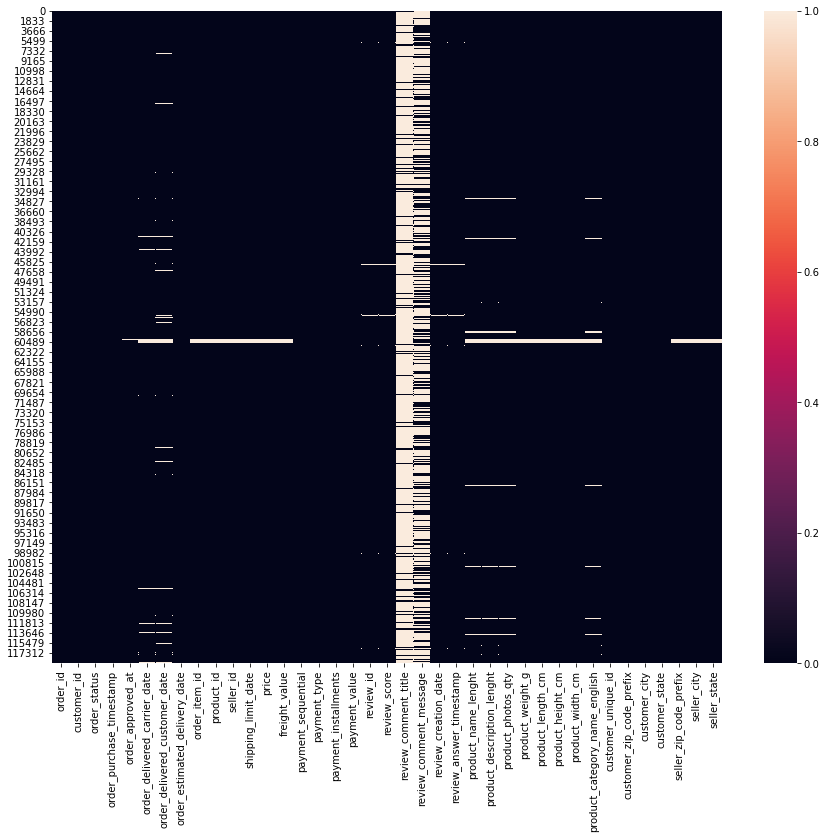

In [25]:
# Checking for null values 
plt.figure(figsize=(15,12))
sns.heatmap(df.isnull())
plt.show()

In [26]:
# Finding the percentage of null values in the dataset

pd.DataFrame(df.isnull().sum()/len(df)*100,columns=["Percentage missing"]).T

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
Percentage missing,0.0,0.0,0.0,0.0,0.148561,1.750837,2.871339,0.0,0.69916,0.69916,0.69916,0.69916,0.69916,0.69916,0.002518,0.002518,0.002518,0.002518,0.83681,0.83681,88.258647,57.827988,0.83681,0.83681,2.133571,2.133571,2.133571,0.715946,0.715946,0.715946,0.715946,2.154554,0.0,0.0,0.0,0.0,0.69916,0.69916,0.69916


In [27]:
# We can see review_comment_title has over 88 % and review_comment_message has over 57% missing values.

In [28]:
# As per the rule if we have more than 40% missing values in a feature we can drop those features

a = pd.DataFrame((df.isnull().sum()/len(df)*100 > 40),columns=["Status"])
a[a["Status"]==True]

,Status
review_comment_title,True
review_comment_message,True


In [29]:
# dropping the features review_comment_title,review_comment_message

df.drop(["review_comment_title","review_comment_message"],axis=1,inplace=True)

In [30]:
df.shape

(119143, 37)

In [31]:
df.isnull().sum()/len(df)*100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.148561
order_delivered_carrier_date     1.750837
order_delivered_customer_date    2.871339
order_estimated_delivery_date    0.000000
order_item_id                    0.699160
product_id                       0.699160
seller_id                        0.699160
shipping_limit_date              0.699160
price                            0.699160
freight_value                    0.699160
payment_sequential               0.002518
payment_type                     0.002518
payment_installments             0.002518
payment_value                    0.002518
review_id                        0.836810
review_score                     0.836810
review_creation_date             0.836810
review_answer_timestamp          0.836810
product_name_lenght              2.133571
product_description_lenght       2

In [32]:
# Since the missing the values in the rest of the features is below 5%  we can use KNNImputer 
# But the KNNImputer can be used only on numerical variables
# So we are splitting categorical features and numerical features

In [33]:
df_cat = df.select_dtypes(exclude=np.number)
df_num = df.select_dtypes(include=np.number)

In [34]:
# Performing KNNImputation on numerical datas
kn = KNNImputer() # Loading the KNNImputer function
df_num_imp = pd.DataFrame(kn.fit_transform(df_num),columns=df_num.columns)

In [35]:
# Checking for missing values after imputation

df_num_imp.isnull().sum()

order_item_id                 0
price                         0
freight_value                 0
payment_sequential            0
payment_installments          0
payment_value                 0
review_score                  0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
customer_zip_code_prefix      0
seller_zip_code_prefix        0
dtype: int64

In [36]:
# We can see there are no missing values after the imputation

In [37]:
# Filling missing values in categorical columns
# Since the missing values in categorical datas are less than 5% we can use mode imputation

In [38]:
# Creating a for loop to fill the missing values in each feature

for i in df_cat.columns:
    df_cat[i].fillna(df_cat[i].mode()[0],inplace=True)

In [39]:
# Checking for null values now

df_cat.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
product_id                       0
seller_id                        0
shipping_limit_date              0
payment_type                     0
review_id                        0
review_creation_date             0
review_answer_timestamp          0
product_category_name_english    0
customer_unique_id               0
customer_city                    0
customer_state                   0
seller_city                      0
seller_state                     0
dtype: int64

In [40]:
# There are no null null values after mode imputation

In [41]:
# Now we will be concating numerical and categorical dataframe along the column

In [42]:
master_df = pd.concat([df_cat,df_num_imp],axis=1)

In [43]:
# Checking for any null values in the master dataframe after the missing value treatment

master_df.isnull().values.any()

False

In [44]:
# Now we have cleaned the data 

In [45]:
master_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,payment_type,review_id,review_creation_date,review_answer_timestamp,product_category_name_english,customer_unique_id,customer_city,customer_state,seller_city,seller_state,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,credit_card,a54f0611adc9ed256b57ede6b6eb5114,2017-10-11 00:00:00,2017-10-12 03:43:48,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,maua,SP,1.0,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3149.0,9350.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,voucher,a54f0611adc9ed256b57ede6b6eb5114,2017-10-11 00:00:00,2017-10-12 03:43:48,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,maua,SP,1.0,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3149.0,9350.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,voucher,a54f0611adc9ed256b57ede6b6eb5114,2017-10-11 00:00:00,2017-10-12 03:43:48,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,maua,SP,1.0,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3149.0,9350.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,credit_card,b46f1e34512b0f4c74a72398b03ca788,2017-08-19 00:00:00,2017-08-20 15:16:36,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,maua,SP,1.0,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3366.0,9350.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,credit_card,dc90f19c2806f1abba9e72ad3c350073,2017-08-08 00:00:00,2017-08-08 23:26:23,housewares,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,maua,SP,1.0,29.99,7.78,1.0,1.0,37.77,5.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2290.0,9350.0


In [46]:
#changing the Data Types of below mentioned colums from object to datetime format
time_columns=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
              'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date','review_creation_date',
              'review_answer_timestamp']

In [47]:
for i in time_columns:
    master_df[i] =  pd.to_datetime(master_df[i], format='%Y%m%d %H:%M:%S.%f')

In [48]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              119143 non-null  datetime64[ns]
 5   order_delivered_carrier_date   119143 non-null  datetime64[ns]
 6   order_delivered_customer_date  119143 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119143 non-null  datetime64[ns]
 8   product_id                     119143 non-null  object        
 9   seller_id                      119143 non-null  object        
 10  shipping_limit_date            119143 non-null  datetime64[ns]
 11  

In [49]:
# We can see dates are in date datatype

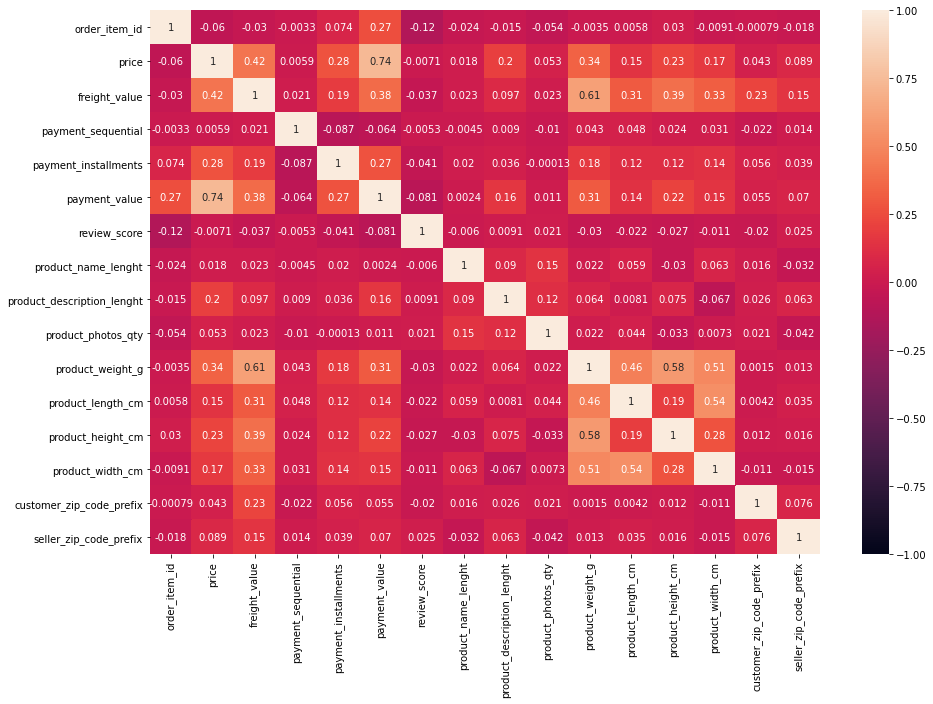

In [50]:
# Relationship between the fetaures
corr= master_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,annot=True,vmin=-1,vmax=1)
plt.show()

In [51]:
master_copy = master_df.copy()

In [52]:
master_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'product_id', 'seller_id', 'shipping_limit_date', 'payment_type', 'review_id', 'review_creation_date', 'review_answer_timestamp', 'product_category_name_english', 'customer_unique_id', 'customer_city', 'customer_state', 'seller_city', 'seller_state', 'order_item_id', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'review_score', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_zip_code_prefix', 'seller_zip_code_prefix'], dtype='object')

In [53]:
# dropping unwanted columns
master_df.drop(["review_id","review_creation_date","review_answer_timestamp",'customer_zip_code_prefix','customer_city','customer_state',"seller_zip_code_prefix","seller_city"],axis=1,inplace=True)

In [54]:
master_df.shape

(119143, 29)

In [55]:
# Converting to date since we don't need the exact time

dates = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
         'order_delivered_customer_date', 'order_estimated_delivery_date','shipping_limit_date']
for i in dates:
    master_df[i]=pd.to_datetime(master_df[i]).dt.date

In [56]:
master_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,payment_type,product_category_name_english,customer_unique_id,seller_state,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,credit_card,housewares,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,voucher,housewares,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,voucher,housewares,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21,credit_card,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,SP,1.0,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08,credit_card,housewares,ef0996a1a279c26e7ecbd737be23d235,SP,1.0,29.99,7.78,1.0,1.0,37.77,5.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [57]:
## finding the last date on which customer made the purchase

recency=pd.DataFrame(master_df.groupby('customer_unique_id')['order_purchase_timestamp'].max())

In [58]:
recency.head()

,order_purchase_timestamp
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07
0000f46a3911fa3c0805444483337064,2017-03-10
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12
0004aac84e0df4da2b147fca70cf8255,2017-11-14


In [59]:
## we take the maximum date of purchase made by customers as the date to calculate the recency of the purchase
## 2018-10-17
recency['recent_days']=recency['order_purchase_timestamp'].max()-recency['order_purchase_timestamp']
recency['recent_days']=recency['recent_days'].dt.days

In [60]:
recency

,order_purchase_timestamp,recent_days
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,160
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,163
0000f46a3911fa3c0805444483337064,2017-03-10,586
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,370
0004aac84e0df4da2b147fca70cf8255,2017-11-14,337
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,496
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,311
ffff371b4d645b6ecea244b27531430a,2017-02-07,617


In [61]:
## the number of times a unique customer has made purchase
frequency=pd.DataFrame(master_df.groupby('customer_unique_id')['customer_id'].count())

In [62]:
frequency.head(2)

,customer_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1


In [63]:
monetary=pd.DataFrame(master_df[['customer_unique_id','payment_value']].groupby('customer_unique_id')['payment_value'].sum())

In [64]:
monetary.sort_values(by="payment_value",ascending=False)

,payment_value
customer_unique_id,
0a0a92112bd4c708ca5fde585afaa872,109312.64
698e1cf81d01a3d389d96145f7fa6df8,45256.00
c402f431464c72e27330a67f7b94d4fb,44048.00
4007669dec559734d6f53e029e360987,36489.24
ef8d54b3797ea4db1d63f0ced6a906e9,30186.00
...,...
b33336f46234b24a613ad9064d13106d,10.89
bd06ce0e06ad77a7f681f1a4960a3cc6,10.07
317cfc692e3f86c45c95697c61c853a6,9.59


In [65]:
# We can see that "0a0a92112bd4c708ca5fde585afaa872" has a highest monetary value of 109312.64 

In [66]:
# the receny of visit, total monetary spent and freqency of purchase by each customer is found out and merged
df_RFM=pd.merge(recency,frequency,on='customer_unique_id')
df_RFM=pd.merge(df_RFM,monetary,on='customer_unique_id')

In [67]:
df_RFM.head(1)

,order_purchase_timestamp,recent_days,customer_id,payment_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,160,1,141.9


In [68]:
#Renaming columns to avoid confusion
df_RFM.rename(columns={"customer_id":"Frequency","payment_value":"Monetary","recent_days":"Recency"},inplace=True)

In [69]:
df_RFM.drop("order_purchase_timestamp",axis=1,inplace=True)

In [70]:
df_RFM.head(2)

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19


In [71]:
master_df_RFM = pd.merge(master_df,df_RFM,on="customer_unique_id")

In [72]:
master_df_RFM.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,payment_type,product_category_name_english,customer_unique_id,seller_state,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Recency,Frequency,Monetary
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,credit_card,housewares,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,voucher,housewares,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,voucher,housewares,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82
3,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04,2017-09-04,2017-09-04,2017-09-05,2017-09-15,9abb00920aae319ef9eba674b7d2e6ff,1771297ac436903d1dd6b0e9279aa505,2017-09-11,credit_card,baby,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,35.39,8.72,1.0,1.0,44.11,5.0,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,380,4,82.82
4,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21,credit_card,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,SP,1.0,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,428,1,37.77


In [73]:
# Since we have found the RFM for every unique customers we will be dropping customer_id,customer_unique_id,order_item_id
# order_purchase_timestamp,order_approved_at,ordered_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date

In [74]:
master_df_RFM.drop(["customer_id","order_purchase_timestamp","order_id","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","product_id","order_estimated_delivery_date","seller_id","shipping_limit_date","order_item_id","customer_unique_id"],
                   axis=1,inplace=True)

In [75]:
master_df_RFM.head()

,order_status,payment_type,product_category_name_english,seller_state,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Recency,Frequency,Monetary
0,delivered,credit_card,housewares,SP,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82
1,delivered,voucher,housewares,SP,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82
2,delivered,voucher,housewares,SP,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82
3,delivered,credit_card,baby,SP,35.39,8.72,1.0,1.0,44.11,5.0,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,380,4,82.82
4,delivered,credit_card,housewares,SP,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,428,1,37.77


In [76]:
master_df_RFM.shape

(119143, 20)

In [77]:
len(master_df_RFM["product_category_name_english"].value_counts())

71

In [78]:
# Since product category is high we will be dropping product_cat_name
master_df_RFM.drop("product_category_name_english",axis=1,inplace=True)

### FEATURE ENGINEERING CHURN VARIABLE

In [79]:
# Segregating the customers using recency and frequenct if the customer has frequency >=1 and has recency less than 90 days he is an active customer
chrn = []
for j in master_df_RFM.index:
    if (master_df_RFM["Frequency"][j] > 1) and (master_df_RFM["Recency"][j] >= 365):
        chrn.append(0) # Low value
    elif (master_df_RFM["Frequency"][j] == 1) and (master_df_RFM["Recency"][j] >= 365):
        chrn.append(1) # Mid value
    elif (master_df_RFM["Frequency"][j] >= 1) and (master_df_RFM["Recency"][j] < 90):
        chrn.append(2) # Active
    elif (master_df_RFM["Frequency"][j] >= 1) and (master_df_RFM["Recency"][j] < 365):
        chrn.append(3) # High value
master_df_RFM["CHURN STATS"] = np.array(chrn)

In [80]:
len(master_df_RFM["seller_state"].value_counts()) 

23

In [81]:
# There are 23 unique cities in the seller state 

In [82]:
# https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population

# Segregating the states to its particular zones

#NE -  PE, MA, CE, RN, PB, PI, SE
#NW -  AM, AC
#SE -  SP, MG, RJ, ES
#SW -  MS
#South -PR, SC, RS
#West - DF, GO, MT
#East - BA
#North - RO, PA

In [83]:
zones = {"PE":"NE","MA":"NE","CE":"NE","RN":"NE","PB":"NE","PI":"NE","SE":"NE","AM":"NW","AC":"NW","SP":"SE","MG":"SE","RJ":"SE",
        "ES":"SE","MS":"SW","PR":"S","SC":"S","RS":"S","DF":"W","GO":"W","MT":"W","BA":"E","RO":"N","PA":"N"}
master_df_RFM["seller_state"].replace(zones,inplace=True)

In [84]:
master_df_RFM["seller_state"].value_counts()

SE    99950
S     15661
W      1646
NE     1100
E       700
SW       60
N        22
NW        4
Name: seller_state, dtype: int64

In [85]:
master_df_RFM.head()

,order_status,payment_type,seller_state,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Recency,Frequency,Monetary,CHURN STATS
0,delivered,credit_card,SE,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0
1,delivered,voucher,SE,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0
2,delivered,voucher,SE,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0
3,delivered,credit_card,SE,35.39,8.72,1.0,1.0,44.11,5.0,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,380,4,82.82,0
4,delivered,credit_card,SE,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,428,1,37.77,1


In [86]:
master_df_RFM["CHURN STATS"].value_counts()/len(master_df_RFM)*100

3    60.497889
1    20.410767
0     9.555744
2     9.535600
Name: CHURN STATS, dtype: float64

<AxesSubplot:xlabel='CHURN STATS', ylabel='count'>

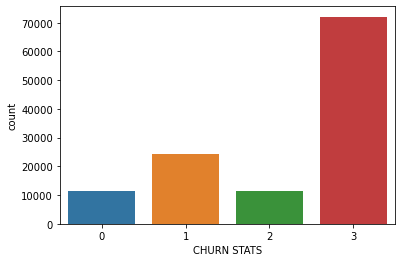

In [87]:
sns.countplot(master_df_RFM["CHURN STATS"])

In [88]:
# We can see that the customers who didn't return back is about 60.49 % 
# The customers who have mid value is about 20.41%
# The customers who are present actively is 9.53%
# The premium customers is about 9.55%

In [89]:
master_df_RFM.head()

,order_status,payment_type,seller_state,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Recency,Frequency,Monetary,CHURN STATS
0,delivered,credit_card,SE,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0
1,delivered,voucher,SE,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0
2,delivered,voucher,SE,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0
3,delivered,credit_card,SE,35.39,8.72,1.0,1.0,44.11,5.0,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,380,4,82.82,0
4,delivered,credit_card,SE,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,428,1,37.77,1


In [90]:
master_df_RFM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_status                119143 non-null  object 
 1   payment_type                119143 non-null  object 
 2   seller_state                119143 non-null  object 
 3   price                       119143 non-null  float64
 4   freight_value               119143 non-null  float64
 5   payment_sequential          119143 non-null  float64
 6   payment_installments        119143 non-null  float64
 7   payment_value               119143 non-null  float64
 8   review_score                119143 non-null  float64
 9   product_name_lenght         119143 non-null  float64
 10  product_description_lenght  119143 non-null  float64
 11  product_photos_qty          119143 non-null  float64
 12  product_weight_g            119143 non-null  float64
 13  product_length

In [91]:
# Splitting numerical and categorical datas for encoding
final_df_cat = master_df_RFM.select_dtypes(exclude=np.number)
final_df_num = master_df_RFM.select_dtypes(include=np.number)

In [92]:
final_df_cat_dummies = pd.get_dummies(final_df_cat,drop_first=True)

In [93]:
final_df_cat_dummies.head()

,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,seller_state_N,seller_state_NE,seller_state_NW,seller_state_S,seller_state_SE,seller_state_SW,seller_state_W
0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [94]:
final_dataframe = pd.concat([final_df_num,final_df_cat_dummies],axis=1)

In [95]:
final_dataframe.head()

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Recency,Frequency,Monetary,CHURN STATS,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,seller_state_N,seller_state_NE,seller_state_NW,seller_state_S,seller_state_SE,seller_state_SW,seller_state_W
0,29.99,8.72,1.0,1.0,18.12,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,29.99,8.72,3.0,1.0,2.00,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,29.99,8.72,2.0,1.0,18.59,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,380,4,82.82,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,35.39,8.72,1.0,1.0,44.11,5.0,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,380,4,82.82,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,29.99,7.78,1.0,3.0,37.77,4.0,40.0,268.0,4.0,500.0,19.0,8.0,13.0,428,1,37.77,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### MODEL BUILDING

In [126]:
# Since we are predicting Churn stats
Y = final_dataframe["CHURN STATS"]
X = final_dataframe.drop("CHURN STATS",axis=1)

In [97]:
# Multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data.sort_values(by="VIF",ascending=False)

,feature,VIF
18,order_status_delivered,229.014305
31,seller_state_SE,149.375690
6,product_name_lenght,25.952137
30,seller_state_S,24.121336
4,payment_value,11.602120
5,review_score,10.080163
12,product_width_cm,7.976646
10,product_length_cm,6.983092
2,payment_sequential,6.480735
0,price,6.249830


In [98]:
# The first 5 features has high vif values so will be dropping those

X.drop(["order_status_delivered","payment_value","product_name_lenght","seller_state_S","payment_value"],axis=1,inplace=True)

In [99]:
# We will also be dropping Recency and Frequency

X.drop(["Recency","Frequency"],axis=1,inplace=True)

In [100]:
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.3,random_state=42)

In [101]:
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((83400, 28), (35743, 28), (83400,), (35743,))

In [102]:
train_x.head()

,price,freight_value,payment_sequential,payment_installments,review_score,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,Monetary,order_status_canceled,order_status_created,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,seller_state_N,seller_state_NE,seller_state_NW,seller_state_SE,seller_state_SW,seller_state_W
65518,11.49,19.04,1.0,1.0,4.0,371.0,2.0,125.0,20.0,13.0,17.0,30.53,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
57137,12.99,5.07,1.0,1.0,5.0,575.0,1.0,300.0,35.0,10.0,25.0,244.62,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
10307,65.99,25.74,1.0,1.0,1.0,672.0,3.0,350.0,17.0,6.0,20.0,145.35,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
65880,169.90,15.95,1.0,2.0,5.0,687.0,1.0,640.0,23.0,18.0,18.0,581.68,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
105450,54.90,24.93,2.0,1.0,5.0,122.0,1.0,1200.0,45.0,10.0,15.0,79.83,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [103]:
def get_train_report(model):
    train_pred = model.predict(train_x)
    return(classification_report(train_y, train_pred))

In [104]:
def get_test_report(model):
    test_pred = model.predict(test_x)
    return(classification_report(test_y, test_pred))

### Decision Tree Classifier

In [105]:
dt_model = DecisionTreeClassifier(criterion = 'entropy',
                                  max_depth = 5,
                                  min_samples_split = 4,
                                  max_leaf_nodes = 6,
                                  random_state = 42)

# fit the model using fit() on train data
decision_tree = dt_model.fit(train_x,train_y)

# compute the performance measures on train data
# call the function 'get_train_report'
# pass the decision tree to the function
train_report = get_train_report(decision_tree)

# print the performance measures
print('Train data:\n', train_report)

# compute the performance measures on test data
# call the function 'get_test_report'
# pass the decision tree to the function
test_report = get_test_report(decision_tree)

# print the performance measures
print('Test data:\n', test_report)

Train data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7982
           1       0.00      0.00      0.00     17003
           2       0.00      0.00      0.00      7982
           3       0.60      1.00      0.75     50433

    accuracy                           0.60     83400
   macro avg       0.15      0.25      0.19     83400
weighted avg       0.37      0.60      0.46     83400

Test data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3403
           1       0.00      0.00      0.00      7315
           2       0.00      0.00      0.00      3379
           3       0.61      1.00      0.75     21646

    accuracy                           0.61     35743
   macro avg       0.15      0.25      0.19     35743
weighted avg       0.37      0.61      0.46     35743



### Random Forest Classifier

In [106]:
rf_classification = RandomForestClassifier(n_estimators = 20, random_state = 42)

# use fit() to fit the model on the train set
rf_model = rf_classification.fit(train_x,train_y)

train_report = get_train_report(rf_model)

# print the performace measures
print(train_report) 

test_report = get_test_report(rf_model)

# print the performace measures
print(test_report) 


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7982
           1       0.99      0.99      0.99     17003
           2       0.99      0.98      0.99      7982
           3       0.99      1.00      0.99     50433

    accuracy                           0.99     83400
   macro avg       0.99      0.99      0.99     83400
weighted avg       0.99      0.99      0.99     83400

              precision    recall  f1-score   support

           0       0.85      0.64      0.73      3403
           1       0.68      0.52      0.59      7315
           2       0.76      0.31      0.44      3379
           3       0.74      0.90      0.82     21646

    accuracy                           0.74     35743
   macro avg       0.76      0.59      0.64     35743
weighted avg       0.74      0.74      0.73     35743



In [107]:
#As we can see clearly the model is doing good in the train data set but not in the test dataset
#the model is overfitting in the train data , so hyperparameter tunning should be done to reduce the varainace 
#and the improve the model model in the test data set

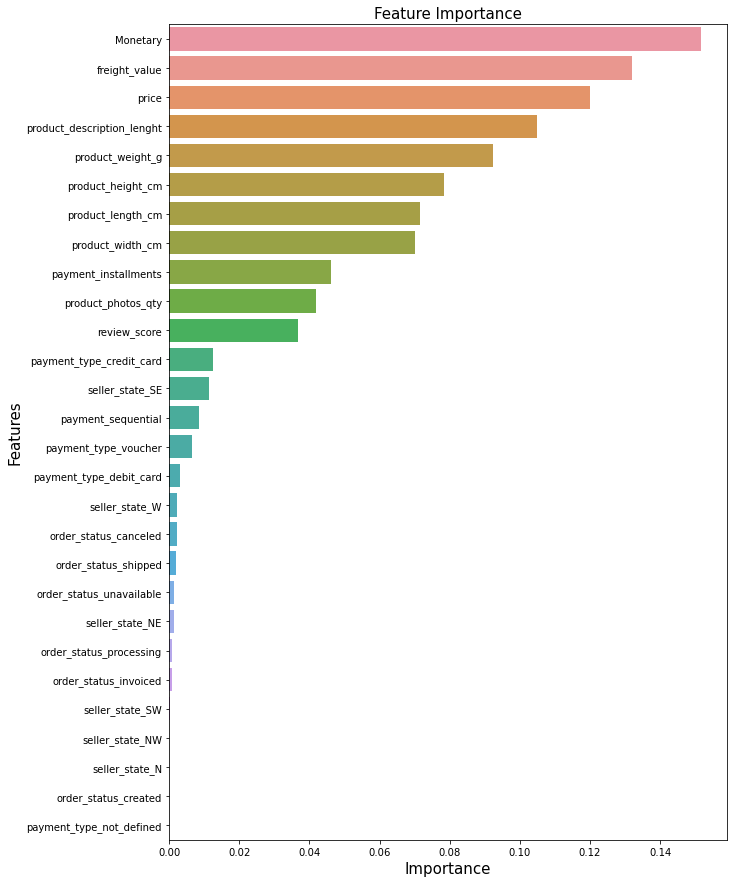

In [108]:
#checking fro the best features 
plt.figure(figsize=(10,15))
important_features = pd.DataFrame({'Features': train_x.columns, 
                                   'Importance': rf_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

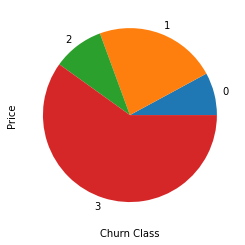

In [136]:
### Insights

## CHURN STATS vs PRICE

final_dataframe.groupby("CHURN STATS")["price"].sum().plot(kind="pie")
plt.ylabel("Price")
plt.xlabel("Churn Class")
plt.show()

In [141]:
final_dataframe.groupby("CHURN STATS")["price"].sum()

CHURN STATS
0    1.137989e+06
1    3.266117e+06
2    1.364870e+06
3    8.622449e+06
Name: price, dtype: float64

In [ ]:
# We can Clearly see that the label 3 customers bring lots of revenue to the company but sadly these customers are the ones who 
# all are labeled with high value. So We should retain the customers inorder to increase the company revenue, since retaining all the
# customers is not possible, company should try to retain atleast 50% of its churning customers inorder to get a revenue of 4 million annualy

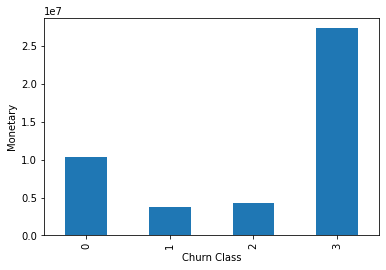

In [135]:
## CHURN STATS vs Monetary

final_dataframe.groupby("CHURN STATS")["Monetary"].sum().plot(kind="bar")
plt.ylabel("Monetary")
plt.xlabel("Churn Class")
plt.show()

In [142]:
final_dataframe.groupby("CHURN STATS")["Monetary"].sum()

CHURN STATS
0    1.030746e+07
1    3.763453e+06
2    4.303662e+06
3    2.734266e+07
Name: Monetary, dtype: float64

In [ ]:
#we can see that for the label 3 the monetary is high compared to the other lables 
#so we need to retain the customers who are likely to leave the company.
#so that we can improve the profit of the company 

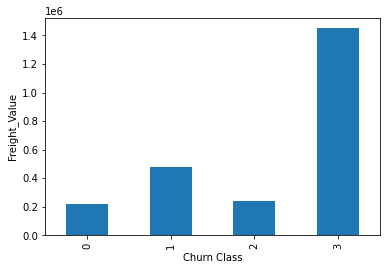

In [139]:
## CHURN STATS vs Freight_Value

final_dataframe.groupby("CHURN STATS")["freight_value"].sum().plot(kind="bar")
plt.ylabel("Freight_Value")
plt.xlabel("Churn Class")
plt.show()

In [143]:
final_dataframe.groupby("CHURN STATS")["freight_value"].sum()

CHURN STATS
0     216568.970
1     481263.808
2     240174.788
3    1449110.574
Name: freight_value, dtype: float64

In [ ]:
#we can clearly see that the freight value for the label 3 is high followed by the label 2

In [109]:
# Since the accuracy score of Random Forest is High we will be proceeding with this algorithm.

In [110]:
# By evalauting the model after hyper parameter tuning it seems to have class imbalance problem
# Reference: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

### Performing oversampling and undersampling

#### Oversampling

In [111]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X,Y)

print('original dataset shape:', Counter(Y))
print('Resample dataset shape', Counter(y_ros))

original dataset shape: Counter({3: 72079, 1: 24318, 0: 11385, 2: 11361})
Resample dataset shape Counter({0: 72079, 1: 72079, 3: 72079, 2: 72079})


In [112]:
train_x,test_x,train_y,test_y = train_test_split(x_ros,y_ros,test_size=0.3,random_state=42)

In [113]:
rf_classification = RandomForestClassifier(n_estimators = 20, random_state = 42,n_jobs=-1)

# use fit() to fit the model on the train set
rf_model = rf_classification.fit(train_x,train_y)

train_report = get_train_report(rf_model)

# print the performace measures
print(train_report) 

test_report = get_test_report(rf_model)

# print the performace measures
print(test_report) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50340
           1       0.99      1.00      0.99     50468
           2       1.00      1.00      1.00     50473
           3       1.00      0.99      0.99     50540

    accuracy                           1.00    201821
   macro avg       1.00      1.00      1.00    201821
weighted avg       1.00      1.00      1.00    201821

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21739
           1       0.87      0.96      0.91     21611
           2       0.95      0.99      0.97     21606
           3       0.94      0.78      0.85     21539

    accuracy                           0.93     86495
   macro avg       0.93      0.93      0.93     86495
weighted avg       0.93      0.93      0.93     86495



#### Undersampling

In [114]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X,Y)

print('original dataset shape:', Counter(Y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({3: 72079, 1: 24318, 0: 11385, 2: 11361})
Resample dataset shape Counter({0: 11361, 1: 11361, 2: 11361, 3: 11361})


In [115]:
train_x,test_x,train_y,test_y = train_test_split(x_rus,y_rus,test_size=0.3,random_state=42)

In [116]:
rf_classification = RandomForestClassifier(n_estimators = 20, random_state = 42)

# use fit() to fit the model on the train set
rf_model = rf_classification.fit(train_x,train_y)

train_report = get_train_report(rf_model)

# print the performace measures
print(train_report) 

test_report = get_test_report(rf_model)

# print the performace measures
print(test_report) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7914
           1       1.00      1.00      1.00      7965
           2       1.00      1.00      1.00      7946
           3       1.00      0.99      1.00      7985

    accuracy                           1.00     31810
   macro avg       1.00      1.00      1.00     31810
weighted avg       1.00      1.00      1.00     31810

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3447
           1       0.68      0.81      0.74      3396
           2       0.69      0.65      0.67      3415
           3       0.62      0.45      0.52      3376

    accuracy                           0.71     13634
   macro avg       0.70      0.71      0.70     13634
weighted avg       0.70      0.71      0.70     13634



In [117]:
# Inference : Under Sampling is not effecient so Over sampling is selected for class imbalance problem

In [118]:
# tuned_paramaters = [{'criterion': ['entropy', 'gini'],
#                      'n_estimators': [10, 30, 50, 70, 90],
#                      'max_depth': [10, 15, 20],
#                      'max_features': ['sqrt', 'log2'],
#                      'min_samples_split': [2, 5, 8, 11],
#                      'min_samples_leaf': [1, 5, 9],
#                      'max_leaf_nodes': [2, 5, 8, 11]}]
 
# # instantiate the 'RandomForestClassifier' 
# # pass the 'random_state' to obtain the same samples for each time you run the code
# random_forest_classification = RandomForestClassifier(random_state = 10)

# # use GridSearchCV() to find the optimal value of the hyperparameters
# # estimator: pass the random forest classifier model
# # param_grid: pass the list 'tuned_parameters'
# # cv: number of folds in k-fold i.e. here cv = 5
# rf_grid = GridSearchCV(estimator = random_forest_classification, 
#                        param_grid = tuned_paramaters, 
#                        cv = 5,n_jobs=-1)

# # use fit() to fit the model on the train set
# rf_grid_model = rf_grid.fit(train_x, train_y)

# get the best parameters
# print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

In [119]:
### Tuned Model
# random_forest_classification = RandomForestClassifier(random_state = 10,criterion="entropy",max_depth=10,max_features="sqrt",
#                                                       max_leaf_nodes=2,min_samples_leaf=1,min_samples_split=2,n_estimators=10)

# rf_tuned_model = random_forest_classification.fit(train_x,train_y)
# train_report = get_train_report(rf_tuned_model)

# # print the performace measures
# print(train_report) 

# test_report = get_test_report(rf_tuned_model)

# # print the performace measures
# print(test_report)

### Dropping Unecessary features and again building the model

In [120]:
X1 = X.copy()
X1.drop(["payment_type_not_defined","order_status_created","seller_state_NW","seller_state_N","seller_state_SW"],
        axis=1,inplace=True)

In [121]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X1,Y)

In [122]:
# over Sampling
train_x,test_x,train_y,test_y = train_test_split(x_ros,y_ros,test_size=0.3,random_state=42)

In [123]:
rf_classification = RandomForestClassifier(n_estimators = 20, random_state = 42)

# use fit() to fit the model on the train set
rf_model = rf_classification.fit(train_x,train_y)

train_report = get_train_report(rf_model)

# print the performace measures
print(train_report) 

test_report = get_test_report(rf_model)

# print the performace measures
print(test_report) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50340
           1       0.99      1.00      0.99     50468
           2       1.00      1.00      1.00     50473
           3       1.00      0.99      0.99     50540

    accuracy                           1.00    201821
   macro avg       1.00      1.00      1.00    201821
weighted avg       1.00      1.00      1.00    201821

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21739
           1       0.87      0.96      0.91     21611
           2       0.95      0.99      0.97     21606
           3       0.95      0.78      0.85     21539

    accuracy                           0.93     86495
   macro avg       0.93      0.93      0.93     86495
weighted avg       0.93      0.93      0.93     86495



In [124]:
# tuned_paramaters = [{'criterion': ['entropy', 'gini'],
#                      'n_estimators': [10, 30, 50, 70, 90],
#                      'max_depth': [10, 15, 20],
#                      'max_features': ['sqrt', 'log2'],
#                      'min_samples_split': [2, 5, 8, 11],
#                      'min_samples_leaf': [1, 5, 9],
#                      'max_leaf_nodes': [2, 5, 8, 11]}]
 
# # instantiate the 'RandomForestClassifier' 
# # pass the 'random_state' to obtain the same samples for each time you run the code
# random_forest_classification = RandomForestClassifier(random_state = 10)

# # use GridSearchCV() to find the optimal value of the hyperparameters
# # estimator: pass the random forest classifier model
# # param_grid: pass the list 'tuned_parameters'
# # cv: number of folds in k-fold i.e. here cv = 5
# rf_grid = GridSearchCV(estimator = random_forest_classification, 
#                        param_grid = tuned_paramaters, 
#                        cv = 5,n_jobs=-1)

# # use fit() to fit the model on the train set
# rf_grid_model = rf_grid.fit(train_x, train_y)

# get the best parameters
# print('Best parameters for random forest classifier: ', rf_grid_model.best_params_, '\n')

In [125]:
## Tuned Model
random_forest_classification = RandomForestClassifier(random_state = 10,criterion="entropy",max_depth=10,max_features="sqrt",
                                                      max_leaf_nodes=2,min_samples_leaf=1,min_samples_split=2,n_estimators=10)

rf_tuned_model = random_forest_classification.fit(train_x,train_y)
train_report = get_train_report(rf_tuned_model)

# print the performace measures
print(train_report) 

test_report = get_test_report(rf_tuned_model)

# print the performace measures
print(test_report)

              precision    recall  f1-score   support

           0       0.40      0.56      0.47     50340
           1       0.36      0.69      0.47     50468
           2       0.53      0.08      0.14     50473
           3       0.25      0.14      0.18     50540

    accuracy                           0.37    201821
   macro avg       0.39      0.37      0.31    201821
weighted avg       0.39      0.37      0.31    201821

              precision    recall  f1-score   support

           0       0.40      0.56      0.47     21739
           1       0.36      0.68      0.47     21611
           2       0.54      0.08      0.14     21606
           3       0.25      0.13      0.17     21539

    accuracy                           0.37     86495
   macro avg       0.39      0.36      0.31     86495
weighted avg       0.39      0.37      0.31     86495



In [128]:
rf_classification = RandomForestClassifier(random_state = 42,criterion="gini",n_estimators=20,max_depth=None,min_samples_split=2,min_samples_leaf=1)

# use fit() to fit the model on the train set
rf_model_1 = rf_classification.fit(train_x,train_y)

train_report = get_train_report(rf_model_1)

# print the performace measures
print(train_report) 

test_report = get_test_report(rf_model)

# print the performace measures
print(test_report) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50340
           1       0.99      1.00      0.99     50468
           2       1.00      1.00      1.00     50473
           3       1.00      0.99      0.99     50540

    accuracy                           1.00    201821
   macro avg       1.00      1.00      1.00    201821
weighted avg       1.00      1.00      1.00    201821

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21739
           1       0.87      0.96      0.91     21611
           2       0.95      0.99      0.97     21606
           3       0.95      0.78      0.85     21539

    accuracy                           0.93     86495
   macro avg       0.93      0.93      0.93     86495
weighted avg       0.93      0.93      0.93     86495



In [ ]:
#from the above model the we clearly see that the model accuracy in train and test data is increased 
#for train dataset the accuracy score is 100 but for the test dataset the score is 93%

In [135]:
from sklearn.metrics import confusion_matrix

### XG Boost

In [123]:
# import linrary
from xgboost import XGBClassifier

xgb_model = XGBClassifier().fit(train_x, train_y)

# predict
xgb_y_predict = xgb_model.predict(test_x)

# accuracy score
xgb_score = accuracy_score(xgb_y_predict,test_y)

print('Accuracy score is:', xgb_score)

[10:13:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score is: 0.7582866061622059


In [ ]:
#XG boost accuracys is 75.8%

### AdaBoost Classifier

In [124]:
abc = AdaBoostClassifier(n_estimators=20,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(train_x,train_y)

#Predict the response for test dataset
y_pred = model.predict(test_x)
print("Accuracy:",accuracy_score(test_y, y_pred))

Accuracy: 0.4651020290190184


In [ ]:
# #from sklearn.ensemble import AdaBoostClassifier

# # Import Support Vector Classifier
# from sklearn.svm import SVC
# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
# svc=SVC(probability=True, kernel='linear')

# # Create adaboost classifer object
# abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# # Train Adaboost Classifer
# model = abc.fit(train_x,train_y)

# #Predict the response for test dataset
# y_pred = model.predict(test_x)


# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

### Manually combining undersampling and oversampling

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [ ]:
model = RandomForestClassifier()
# define resampling
over = RandomOverSampler(sampling_strategy=1)
under = RandomUnderSampler(sampling_strategy=1)
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

### Combined SMOTE and Edited Nearest Neighbors resampling 

In [ ]:
# define resampling
resample = SMOTEENN()
# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

### Combined SMOTE and Tomek Links resampling

In [ ]:
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))